In [1]:
# @title Loading data
from google.colab import drive
drive.mount('/content/drive')


file_path = '/content/drive/My Drive/Colab_Notebooks/lorentz_long_x.csv'

import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

Mounted at /content/drive


In [2]:
# @title Loading optuna
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import networkx as nx
import csv

!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.0 MB/s eta 0:00:00


Data length: 1048575


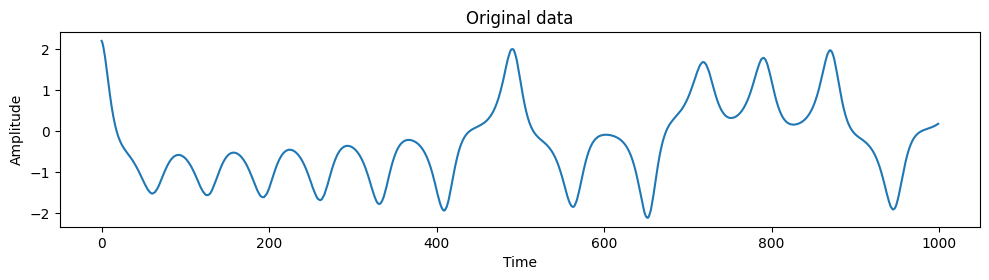

In [3]:
# @title Data reshaping

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv


# find missing values
nan_indices = np.where(np.isnan(data))

# delete missing values
data = np.delete(data, nan_indices)

# average and standard deviation
mean_value = np.mean(data)
std_dev = np.std(data)

# Standardization
data = (data - mean_value) / std_dev


print('Data length:',data.size)

#######
# Visualization

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(data[:1000])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()


Weight function of RealtimeFilter

$$\Psi(t)=
 \underbrace{\left(d_1\cos\left(\frac{t}{\pi r_1}\right)+d_2\cos\left(\frac{ t}{\pi r_2}\right)\right)}_{passing\ freq}
 \underbrace{\frac{(width+t)^c}{width^c}}_{band\ width}$$

In [4]:
# @title Definitions of RealtimeFilter and ``dictionary" for pattern extraction

from scipy import signal

################
#Sigmoid function

def sigmoid(x,a,b):
    return 1 / (1 + np.exp(-a*(x-b)))

################
#RealtimeFilter code
################

class rb_filter:
    def __init__(self, r_1, r_2, c,d_1,d_2, width, height, delta_t=1):

        self.width = width
        self.t_w = np.arange(-self.width, 0, delta_t)
        self.weight =  (d_1*np.cos(self.t_w/(np.pi*r_1))+d_2*np.cos(self.t_w/(np.pi*r_2)))* ((width+self.t_w)**c)/(width**c)
        self.delta_t = delta_t
        self.weight = self.weight / height



    def calc(self, data,T_train):
        data_flt = np.zeros(T_train)
        data_flt[:] = np.nan
        for i in range(self.width, T_train):
            data_flt[i] = np.sum(data[i-self.width+1:i+1]*self.weight)
        return data_flt

    def timeweight(self):
        return self.t_w, self.weight


def auto_correlation(data1_in, data2_in, width,lg):
    n = len(data1_in)
    mean1 = np.mean(data1_in[width:n-width])
    mean2 = np.mean(data2_in[width:n-width])
    numerator = np.sum((data1_in[width:n - width- lg] - mean1) * (data2_in[width + lg:n-width] - mean2))
    denominator = np.sqrt(np.sum((data1_in[width:n-width-lg] - mean1) ** 2)) * np.sqrt(np.sum((data2_in[width +lg: n-width] - mean2) ** 2))
    return numerator / denominator

########################################
###Dictionary for pattern extraction
########################################

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv
import math
from collections import Counter, defaultdict

#Extract patterns and next values

def extract_patterns_and_next_values(discretized_data, max_dim,min_count, min_dim):

    patterns = []
    next_values = defaultdict(list)
    pattern_counts = Counter()


#Collect pair of pattern and next value

    for dim in range(max_dim, min_dim, -1):
        num_patterns = len(discretized_data) - dim

        for i in range(num_patterns):
            pattern = tuple(discretized_data[i:i+dim])  #Pattern
            next_value = discretized_data[i+dim]        #next value
            patterns.append(pattern)
            next_values[pattern].append(next_value)
            pattern_counts[pattern] += 1


# Delete fewer occurrences
    patterns = [pattern for pattern in patterns if pattern_counts[pattern] >= min_count]
    next_values = {pattern: values for pattern, values in next_values.items() if pattern_counts[pattern] >= min_count}

# Collect occurances of each patterns into frequency_array
    filtered_pattern_counts = {pattern: count for pattern, count in pattern_counts.items() if count >= min_count}
    frequency_array = np.array(list(filtered_pattern_counts.values()))



#In ``next_values", there already exist pairs of pattern and next value

    assigned_values, assigned_value_counts = assign_most_frequent_next_value_to_patterns(next_values)


    # calculate win_vote_rate
    win_vote_rate = {}
    for pattern in assigned_values:
        if pattern in pattern_counts:
            win_vote_rate[pattern] = float(assigned_value_counts[pattern]) / float(pattern_counts[pattern])


    return patterns, next_values, frequency_array, filtered_pattern_counts, win_vote_rate


#########
##Assign the most frequent next value to each patterns

def assign_most_frequent_next_value_to_patterns(next_values):
    assigned_values = {}
    assigned_value_counts = {}
    for dim in range(max_dim, min_dim, -1):

        for pattern, values in next_values.items():
            counts = Counter(values)
            most_common_value = counts.most_common(1)[0][0]
            assigned_values[pattern] = most_common_value
            assigned_value_counts[pattern] = counts[most_common_value]
    return assigned_values, assigned_value_counts


##Fitting original data to disretized range

def discretize_time_series(data, inverse_cdf_values):
    discretized_data = []
    for value in data:

        nearest_value = min(inverse_cdf_values, key=lambda x: abs(x - value))
        discretized_data.append(nearest_value)

    return discretized_data

In [5]:
# @title Hyperparameter: Bayesian optimization for RealtimeFilter

T_train    = 800        #Training length
n_trials   = 50         #number of trials for optuna
max_dim    = 40         #Max pattern length
min_dim    = 5          #Min pattern length
min_count  = 5          #delete patterns if occurrence is fewer than this
n_bins     = 10         #number of partitions of range
min_win_vote_rate =0.9  #minimum requirement for win_vote_rate

In [6]:
# @title Implementation of Bayesian optimization of RealtimeFilter

%%time

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

print(len(data))


#Initial filter height is 1

height=1

#####################################
#We can load (in csv file) and reuse the past trials


file_path = 'optuna_filter_params.csv'
past_trials = []

if os.path.exists(file_path):

   with open(file_path, mode='r', newline='') as file:
       reader = csv.DictReader(file)
       for row in reader:

        # Data processing and incorporation into past_trials
           trial_data = {
               'value': float(row['value']),
               'params': {
                   'r_1': float(row['r_1']),
                   'r_2': float(row['r_2']),
                   'c': float(row['c']),
                   'd_1': float(row['d_1']),
                   'd_2': float(row['d_2']),
                   'width': int(row['width'])
               }
           }
           past_trials.append(trial_data)



# Creating an Optuna Study
study = optuna.create_study(direction="maximize")


###############


# Add past attempts to study
for trial in past_trials:

    if 'value' not in trial:
        print(f"Skipping trial as it does not contain 'value': {trial}")
        continue

    try:
          value = float(trial['value'])  # Guarantee that value is a float type
    except ValueError as e:
          print(f"Error converting trial value to float: {e}")
          continue  # Proceed to the next TRIAL


    frozen_trial = FrozenTrial(
        number=study._storage.get_n_trials(study._study_id),
        state=TrialState.COMPLETE,
        value=trial['value'],
        datetime_start=datetime.now(),
        datetime_complete=datetime.now(),
        params=trial['params'],
        distributions={
            'r_1': optuna.distributions.FloatDistribution(2.5, 8),#Especially on the high-frequency side, adjust while checking the SMOOTHING!
            'r_2': optuna.distributions.FloatDistribution(2.5, 8),#Especially on the high-frequency side, adjust while checking the SMOOTHING!
            'c': optuna.distributions.FloatDistribution(0.2, 1),
            'd_1': optuna.distributions.FloatDistribution(0, 10),
            'd_2': optuna.distributions.FloatDistribution(0, 10),
            'width': optuna.distributions.IntUniformDistribution(20, 150),
        },
        user_attrs={},
        system_attrs={},
        intermediate_values={},
        trial_id=study._storage.create_new_trial(study._study_id)
    )
    study.add_trial(frozen_trial)

# Objective Function Definition
def objective(trial):
    r_1 = trial.suggest_float("r_1", 2.5, 8)#Especially on the high-frequency side, adjust while checking the SMOOTHING!
    r_2 = trial.suggest_float("r_2", 2.5, 8)#Especially on the high-frequency side, adjust while checking the SMOOTHING!
    c = trial.suggest_float("c", 0.2, 1)
    d_1 = trial.suggest_float("d_1", 0, 10)
    d_2 = trial.suggest_float("d_2", 0, 10)
    width = trial.suggest_int("width", 20, 150)



############
# Apply Filter
    delta_t = 1
    filter = rb_filter(r_1, r_2, c, d_1, d_2,width, delta_t)
    data_flt = filter.calc(data,T_train)
    data_flt = np.nan_to_num(data_flt, nan=0.0)



#####################
#Discretize value range using cumulative distribution function (CDF)
#####################


# Calculate cumulative distribution function (CDF)
    cdf_values, bin_edges = np.histogram(data_flt[0:T_train], bins='auto', density=True)
    cdf_values = np.cumsum(cdf_values)

# Generates equally spaced probability values
    probability_values = np.linspace(0, 1, n_bins + 1)

# Compute inverse CDF to obtain n_bins values
    inverse_cdf_values = np.interp(probability_values, cdf_values / cdf_values[-1], bin_edges[:-1])


    discretized_data= None
    pattens =None
    next_values = None
    assigned_values = None


# Fitting data to discrete values
    discretized_data = np.array(discretize_time_series(data_flt[0:T_train], inverse_cdf_values))

    patterns, next_values, frequency_array, filtered_pattern_counts, win_vote_rate = \
    extract_patterns_and_next_values(discretized_data, max_dim,min_count, min_dim)

#################

# Count patterns with win_vote_rate greater than or equal to ``min_win_vote_rate"
    count_win_vote_rate = sum(1 for rate in win_vote_rate.values() if rate >= min_win_vote_rate)

# Total number of pattern
    total_patterns = len(win_vote_rate)

# Percentage of patterns with win_vote_rate greater than or equal to ``min_win_vote_rate"
    percentage_win_vote_rate = count_win_vote_rate / total_patterns


################
#Require a minimum autocorrelation coefficient to the objective function
################

    max_lag = 40
    ac_data_flt = []

# calculate autocorrelation coefficient

    for i in range(max_lag + 1):
        ac_flt = auto_correlation(data[:T_train],data_flt[:], width, i)
        ac_data_flt.append(ac_flt)


######################
#OBJECTIVE FUNCTION!!!
######################
#we use the Sigmoid function to predetermine the minimum autocorrelation coefficient we want

    max_value = (percentage_win_vote_rate ** 1) *sigmoid(np.max(ac_data_flt),20,0.78)


    return max_value


######################

# Implementation
study.optimize(objective, n_trials)

# Display of optimization results
print("Best trial:")
trial = study.best_trial
print(f"  'params': {trial.params},")
print(f"  'value': {trial.value},")

r_1  = trial.params["r_1"]
r_2  = trial.params["r_2"]
c  = trial.params["c"]
d_1 = trial.params["d_1"]
d_2 = trial.params["d_2"]
width = trial.params["width"]

#####################
# save results to CSV
#####################

current_directory = os.getcwd()
file_path = os.path.join(current_directory, 'optuna_filter_params.csv')


# Write additional CSV files with the latest trial data
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)

# Writing header lines (first time only)
    if file.tell() == 0:
        writer.writerow(['value', 'r_1', 'r_2', 'c', 'd_1', 'd_2', 'width'])

    # Write all trials
    for trial in study.trials:
        r_1_value = trial.params.get('r_1')
        if r_1_value is not None:  #Write only if r_1 is not None
           writer.writerow([
    trial.value,
    trial.params.get('r_1', None),
    trial.params.get('r_2', None),
    trial.params.get('c', None),
    trial.params.get('d_1', None),
    trial.params.get('d_2', None),
    trial.params.get('width', None),
])

[I 2025-02-05 08:51:32,975] A new study created in memory with name: no-name-b9463d82-7b11-4a0d-9913-0e62e3cc1de9


1048575


[I 2025-02-05 08:51:33,622] Trial 0 finished with value: 0.5133961430193691 and parameters: {'r_1': 6.139943192787829, 'r_2': 5.828620947137175, 'c': 0.8291504549069402, 'd_1': 9.625746638914672, 'd_2': 6.654790435136512, 'width': 58}. Best is trial 0 with value: 0.5133961430193691.
[I 2025-02-05 08:51:33,992] Trial 1 finished with value: 0.010148170588417195 and parameters: {'r_1': 5.586552345953201, 'r_2': 6.986684753997692, 'c': 0.21831894013330003, 'd_1': 2.8547304449624953, 'd_2': 5.4361396538694775, 'width': 100}. Best is trial 0 with value: 0.5133961430193691.
[I 2025-02-05 08:51:34,374] Trial 2 finished with value: 0.0003009143822762803 and parameters: {'r_1': 5.984658525596224, 'r_2': 4.678093440932761, 'c': 0.35024235114461305, 'd_1': 1.3430303673155208, 'd_2': 4.852468078559023, 'width': 144}. Best is trial 0 with value: 0.5133961430193691.
[I 2025-02-05 08:51:34,961] Trial 3 finished with value: 0.2385629529047282 and parameters: {'r_1': 3.711806040814194, 'r_2': 7.84055373

Best trial:
  'params': {'r_1': 2.5430468217975384, 'r_2': 6.565463509233478, 'c': 0.6978595994705521, 'd_1': 6.380353617272959, 'd_2': 5.824351642832616, 'width': 80},
  'value': 0.5946266395780695,
CPU times: user 22.5 s, sys: 130 ms, total: 22.7 s
Wall time: 33.7 s


In [7]:
# @title Decisive filtering

best_params = study.best_params  # Get the best parameters

r_1          = best_params["r_1"]
r_2          = best_params["r_2"]
c            = best_params["c"]
d_1          = best_params["d_1"]
d_2          = best_params["d_2"]
width        = best_params["width"]


# Output and check
print(f"r_1: {r_1}")
print(f"r_2: {r_2}")
print(f"c: {c}")
print(f"d_1: {d_1}")
print(f"d_2: {d_2}")
print(f"width: {width}")

r_1: 2.5430468217975384
r_2: 6.565463509233478
c: 0.6978595994705521
d_1: 6.380353617272959
d_2: 5.824351642832616
width: 80


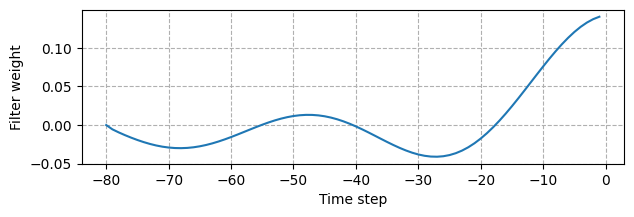

value of objective funct: 0.5946266395780694
autocorrelation: 0.922727922121786


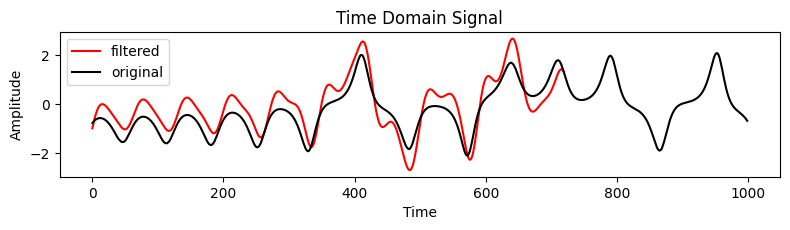

pattern matching rate: 0.6288659793814433 (win vote rate>= 0.9 )
Number of Patterns: 194


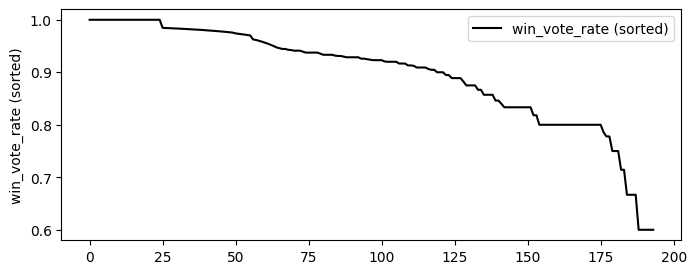

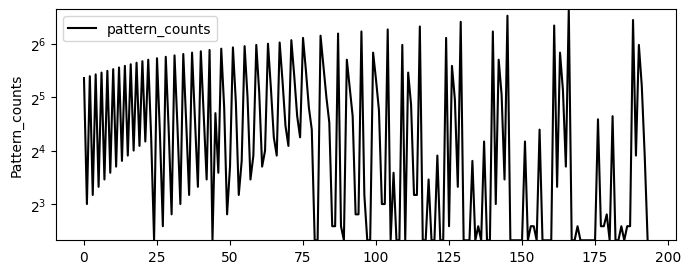

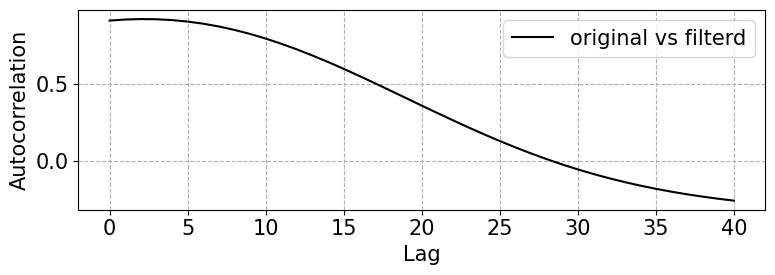

maximum correlation coefficient: 0.922727922121786
lag to achieve maximum value: 2


In [8]:
# @title Reproduction of the deterministic RealtimeFilter

######################
#Filter Standardization

filter = rb_filter(r_1, r_2, c, d_1, d_2,width,1,1)
data_flt = filter.calc(data,T_train)
data_flt = np.nan_to_num(data_flt, nan=0.0)
std_dev_flt = np.std(data_flt)
filter = rb_filter(r_1, r_2, c,d_1,d_2, width, std_dev_flt,1)
######################
#Filter Visualization

t_w, weight = filter.timeweight()
fig = plt.figure(figsize=(7,2), dpi=100)
plt.grid(which='major', linestyle='--', axis='both')
plt.plot(t_w[:], weight[:])
plt.xlabel('Time step')
plt.ylabel('Filter weight')
plt.show()
plt.figure(figsize=(8, 4))

# Apply filter to entire original data (including test data)
data_flt = filter.calc(data,T_train)
data_flt = np.nan_to_num(data_flt, nan=0.0)

#################################
#Implement the same code again!!
#################################

# Calculate cumulative distribution function (CDF)
cdf_values, bin_edges = np.histogram(data_flt[0:T_train], bins='auto', density=True)
cdf_values = np.cumsum(cdf_values)

# Generates equally spaced probability values
probability_values = np.linspace(0, 1, n_bins + 1)

# Compute inverse CDF to obtain n_bins abscissa values
inverse_cdf_values = np.interp(probability_values, cdf_values / cdf_values[-1], bin_edges[:-1])

discretized_data= None
pattens =None
next_values = None
assigned_values = None


# Fit data to discrete values
discretized_data = np.array(discretize_time_series(data_flt[0:T_train], inverse_cdf_values))

patterns, next_values, frequency_array, filtered_pattern_counts, filtered_win_vote_rate = \
extract_patterns_and_next_values(discretized_data, max_dim,min_count,min_dim)

# Count patterns whose win_vote_rate is greater than or equal to ``min_win_vote_rate
count_win_vote_rate = sum(1 for rate in filtered_win_vote_rate.values() if rate >= min_win_vote_rate)

# Total number of patterns
total_patterns = len(filtered_win_vote_rate)

# Percentage of patterns with win_vote_rate greater than or equal to ``min_win_vote_rate
percentage_win_vote_rate = count_win_vote_rate / total_patterns

##########################
#It also requires a minimum of autocorrelation to the objective function
##########################

max_lag = 40
ac_data_flt = []

# Calculate the autocorrelation coefficient
for i in range(max_lag + 1):

    ac_flt = auto_correlation(data[:T_train],data_flt[:], width, i)
    ac_data_flt.append(ac_flt)

print('value of objective funct:', (percentage_win_vote_rate ** 1)*sigmoid(np.max(ac_data_flt),20,0.78))

print('autocorrelation:',np.max(ac_data_flt))

################
# Visualization

plt.subplot(2, 1, 1)
plt.plot(data_flt[width:width+1000], color = "red",label="filtered")
plt.plot(data[width:width+1000], color = "black",label="original")
plt.title('Time Domain Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

# Sorts percentage_win_vote_rate
sorted_values = sorted(filtered_win_vote_rate.values(), reverse=True)
fig, ax1=plt.subplots(figsize=(8,3))
ax1.plot(sorted_values, color='black', label='win_vote_rate (sorted)')
ax1.set_ylabel('win_vote_rate (sorted)')
ax1.legend()


print('pattern matching rate:',percentage_win_vote_rate,'(win vote rate>=',min_win_vote_rate,')')

print('Number of Patterns:',len(frequency_array))

#######################
#Each pattern Frequency

fig, ax1=plt.subplots(figsize=(8,3))

# Convert dictionary values to lists
listed_values = list(filtered_pattern_counts.values())

# Get minimum and maximum values to match the top and bottom width of the box
max_count = max(listed_values)
ax1.set_yscale('log', base=2)  # Change to log scale with base=2 and bottom at 2
ax1.set_ylim(min_count, max_count)  # Set the lower limit of the y-axis to 1 and display the range close to 0
ax1.plot(list(filtered_pattern_counts.values()), color='black', label='pattern_counts')
ax1.set_ylabel('Pattern_counts')
ax1.legend()

#######################
#Visualization

fig = plt.figure(figsize=(8,3), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.plot(ac_data_flt, color = "black",label="original vs filterd")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

max_value = np.max(ac_data_flt)
max_index = np.argmax(ac_data_flt)


print("maximum correlation coefficient:", max_value)
print("lag to achieve maximum value:", max_index)


In [9]:
# @title Output filtered data

df = pd.DataFrame(data_flt[width:])#shift the filterd data
df.to_csv("data_flt.csv", index=False,header=False, encoding="utf-8-sig")